<a href="https://colab.research.google.com/github/honkuro1227/CSE475/blob/main/rl_hw_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

To run this you need several packages. First of all, you need anaconda, which you most likely already have if you're viewing this through jupyter. If not then check the readme on the class page.

System requirements: This should work on all operating systems (Linux, Mac, and Windows). However, several of the environments in the OpenAI-gym require additional simulators which don't aren't easy to get on Windows. In any case, it is strongly recommended that you use Linux, although you should be ok with Mac. (HINT: if you're on Windows check out the Windows Subsystem for Linux (WSL), although it'll make visualizing your policies a little tricky).

Then install the following packages (using conda or pip):

- pytorch --> `conda install pytorch -c pytorch`
- gym --> `pip install gym`
- gym (the cool environments, doesnt work on Windows) --> `pip install gym[all]`
(When install gym[all] don't worry if the mujoco installation doesn't work. That's a more advanced 3D physics simulator that has to be set up separately (see website). Anyway, we don't need it necessarily).

In [ ]:
# If you're using colab, this will install the necessary packages!
!pip install torch
!pip install gym
!pip3 install box2d-py
# !wget https://pjreddie.com/media/files/rlhw_util.py
# due to it need to revise some code in the util, I just copy/paste and revise the suggestion on ed


In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal, Categorical
import pickle

import gym


class Pytorch_Gym_Env(object):
	'''
	Wrapper for OpenAI-Gym environments so they can easily be used with pytorch
	'''

	def __init__(self, env_name, device='cpu'):
		self._env = gym.make(env_name)
		self.spec = self._env.spec
		self.action_space = self._env.action_space
		self.observation_space = self._env.observation_space
		self._device = device

	def reset(self):
		return torch.from_numpy(self._env.reset()).float().to(self._device).view(-1)

	def render(self, *args, **kwargs):
		return self._env.render(*args, **kwargs)

	def to(self, device):
		self._device = device

	def step(self, action):
		action = action.squeeze().detach().cpu().numpy()
		if action.ndim == 0:
			action = action[()]
		obs, reward, done, info = self._env.step(action)
		obs = torch.from_numpy(obs).float().to(self._device).view(-1)
		reward = torch.tensor(reward).float().to(self._device).view(1)
		done = torch.tensor(done).float().to(self._device).view(1)
		return obs, reward, done, info


class Generator(object):
	'''
	Generates rollouts of an environment using a policy
	'''

	def __init__(self, env, policy, horizon=None, drop_last_state=True):

		self.created = 0

		self.policy = policy
		self.env = env

		self.drop_last_state = drop_last_state

		self.horizon = self.env.spec.max_episode_steps if horizon is None else horizon

	def __len__(self):
		return self.created

	def __iter__(self):
		return self

	def __next__(self):
		return self()

	def __call__(self, horizon=None, render=False):

		states = []
		actions = []
		rewards = []

		states.append(self.env.reset())
		horizon = self.horizon if horizon is None else horizon
		for _ in range(horizon):

			if render:
				self.env.render()

			actions.append(self.policy(states[-1]))

			state, reward, done, _ = self.env.step(actions[-1])

			states.append(state)
			rewards.append(reward)

			if done:
				break

		if self.drop_last_state:
			states.pop()

		states = torch.stack(states)
		actions = torch.stack(actions)
		rewards = torch.cat(rewards)

		self.created += 1

		return states, actions, rewards

# Potentially useful utility functions

def compute_returns(rewards, discount):
	'''
	Computes estimate of discounted reward from a sequence of rewards and the discount factor
	:param rewards: 1D tensor of rewards for an episode
	:param discount: discount factor
	:return: returns (discounted rewards)
	'''
	returns = rewards.clone()
	for i in range(len(returns) - 2, -1, -1):
		returns[i] += discount * returns[i + 1]

	return returns

def solve(A, b, out=None, bias=True):
	'''
	Solves for x to minimize (Ax-b)^2
	for some matrix A and vector b
	x is returned as a linear layer (either with or without a bias term)
	Will update out if given, otherwise the output will be a new linear layer
	:param A: D x N pytorch tensor
	:param b: N x 1 pytorch tensor
	:param out: instance of torch.nn.Linear(D,1)
	:param bias: learn a bias term in addition to weights
	:return: torch.nn.Linear(D, 1) instance where the weights (and bias) solve Ax=b
	'''
	# A: M x N
	# b: N x 1
	# x: M x 1

	if bias:
		A = torch.cat([A, torch.ones(*(A.size()[:-1] + (1,))).type_as(A)], -1)

	x, _ = torch.lstsq(b, A)

	if out is None:
		out = nn.Linear(A.size(-1) - 1, b.size(-1), bias=bias).to(A.device)

	out.weight.data.copy_(x[:A.size(-1) - 1].t())

	if bias:
		out.bias.data.copy_(x[A.size(-1) - 1:A.size(-1), 0])

	return out


def MLE(distrib):
	'''
	Returns Maximum liklihood estimate for the given distribution
	:param distrib: pytorch distribution, should be an instance of one of the distributions listed below
	:return: the maximum liklihood estimate for some parameter of the distribution (eg. mode)
	'''
	if isinstance(distrib, Normal):
		return distrib.loc
	elif isinstance(distrib, Categorical):
		return distrib.probs.max(-1)[1]
	raise Exception('Distribution {} not recognized (did you forget to add it to MLE function?)'.format(type(distrib)))


In [ ]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch import distributions
from torch.distributions import Categorical
from itertools import islice

import gym


# Introduction
Welcome to the RL playground. Your task is to implement the REINFORCE and A3C algorithm to solve various OpenAI-gym environments. If you are not familiar with OpenAI-gym, stop reading and visit https://gym.openai.com/envs/ to see all the tasks you can try to solve.

In this homework, we will only look at tasks with a discrete (and small) action space. That being said, both algorithms can be modified slightly to work on tasks with continuous action spaces. For full credit you must fill in the code below so you achieve an average total reward per episode on the cartpole task (CartPole-v1) of at least 499 (for an episode length of 500) for both REINFORCE and A3C. Then you must apply your code to any one other environment in OpenAI-gym, and plot and compare the learning curves (average total reward per episode vs number of episodes trained on) between REINFORCE and A3C (where at least one of the algorithms shows significant improvement from initialization).

Below there's an overview of what every iteration will look like, regardless of whether you want to train or evaluate your agent.

In [ ]:
# from rlhw_util import * # <-- look whats inside here - it could save you a lot of work!

def run_iteration(mode, N, agent, gen, horizon=None, render=False):
    train = mode == 'train'

    if train:

        agent.train()
    else:
        agent.eval()

    states, actions, rewards = zip(*[gen(horizon=horizon, render=render) for _ in range(N)])

    loss = None

    if train:
        loss = agent.learn(states, actions, rewards)

    reward = sum([r.sum() for r in rewards]) / N

    return reward, loss

## The Actor

We need to learn a policy which, given some state, outputs a distribution over all possible actions. As this is deep RL, we'll use a deep neural network to turn the observed state into the requisite action distribution. From this action distribution we can choose what action to take using `get_action`. Pytorch, brilliant as it is, makes our task incredibly easy, as we can use the `torch.distributions.Categorical` class for sampling.

You can experiment with all sorts of network architectures, but remember this is RL, not image classification on ImageNet, so you probably won't need a very deep network (HINT: look below at the state and action dimensionality to get a feel for the task).

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()

        # TODO: Fill in the code to define you policy
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, action_dim)


    def forward(self, state):

        # TODO: Fill in the code to run a forward pass of your policy to get a distribution over actions (HINT: probabilities sum to 1)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x))


    def get_policy(self, state):
        return Categorical(self(state))

    def get_action(self, state, greedy=None):
        if greedy is None:
            greedy = not self.training

        policy = self.get_policy(state)
        return MLE(policy) if greedy else policy.sample()

## The REINFORCE Agent

The Actor defines our policy, but we also have to define how and when we'll be updating our policy, which brings us to the agent. The agent will house the policy (an `Actor`), and can then be used to generate rollouts (using `forward()`) or update the policy given a list of rollouts (using `learn()`).

The REINFORCE algorithm naively uses the returns directly to weight the gradients, however this makes the variance in the policy gradient estimation very large. As a result, we will use a baseline which is a linear model which takes in a state and outputs the return (sounds like a value function, right?). Except we're not going to train our baseline using gradient descent, instead we'll just solve the linear system analytically in every iteration, and use the solution in the next iteration. Don't worry about training/updating the baseline, but you do have to use it in the right way. (Optional experiment: try removing the baseline and see how performance changes)

In [ ]:

class REINFORCE(nn.Module):

    def __init__(self, state_dim, action_dim, discount=0.97, lr=1e-3, weight_decay=1e-4):
        super(REINFORCE, self).__init__()
        self.actor = Actor(state_dim, action_dim)

        self.baseline = nn.Linear(state_dim, 1)

        # TODO: create an optimizer for the parameters of your actor (HINT: use the passed in lr and weight_decay args)
        self.optimizer = optim.RMSprop(self.actor.parameters(), lr=lr, weight_decay=weight_decay)
        self.discount = discount

    def forward(self, state):
        return self.actor.get_action(state)

    def learn(self, states, actions, rewards):
        '''
        Takes in three arguments each of which is a list with equal length. Each element in the list is a
        pytorch tensor with 1 row for every step in the episode, and the columns are state_dim, action_dim,
        and 1, respectively.
        '''

        # TODO: implement the REINFORCE algorithm (HINT: check the slides/papers)

        returns = [compute_returns(rs, discount=self.discount) for rs in rewards]

        states, actions, returns = torch.cat(states), torch.cat(actions), torch.cat(returns)

        self.optimizer.zero_grad()
        loss = 0
        for x, y, z in zip(states, actions, returns):
            loss = loss-self.actor.get_policy(x).log_prob(y) * z

        loss.backward()

        self.optimizer.step()


        error = F.mse_loss(self.baseline(states).squeeze(), returns).detach()
        solve(states, returns, out=self.baseline)
        # solve(states, returns)
        #error = F.mse_loss(self.baseline(states).squeeze(), returns).detach()

        return error.item() # Returns a rough estimate of the error in the baseline (dont worry about this too much)

## The Critic

Now we can introduce a critic, which is essentially a value function to estimate the expected discounted reward of a state.

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()

        # TODO: define your value function network
        self.fc1=nn.Linear(state_dim,128)
        self.fc2=nn.Linear(128,256)
        self.fc3=nn.Linear(256,1)


    def forward(self, state):

        # TODO: apply your value function network to get a value given this batch of states
        x=F.relu(self.fc1(state))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x


## The A3C Agent

Now we can put the actor and critic together using the A3C algorithm. It turns out, the tasks in the gym are all so simple that there is essentially no gain in parallelization, so technically we're implementing A2C (no async), but the RL part is the same.

In [ ]:
class A3C(nn.Module):

    def __init__(self, state_dim, action_dim, discount=0.97, lr=1e-3, weight_decay=1e-4):
        super(A3C, self).__init__()
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)

        # TODO: create an optimizer for the parameters of your actor (HINT: use the passed in lr and weight_decay args)
        # (HINT: the actor and critic have different objectives, so how many optimizers do you need?)
        self.optactor = optim.RMSprop(self.actor.parameters(), lr=lr, weight_decay=weight_decay)
        self.optcritic = optim.Adam(self.critic.parameters(), lr=lr, weight_decay=weight_decay)

        self.discount = discount

    def forward(self, state):
        return self.actor.get_action(state)

    def learn(self, states, actions, rewards):

        returns = [compute_returns(rs, discount=self.discount) for rs in rewards]

        states, actions, returns = torch.cat(states), torch.cat(actions), torch.cat(returns)

        # TODO: implement A3C (HINT: algorithm details found in A3C paper supplement)
        # (HINT2: the algorithm is actually very similar to REINFORCE, the only difference is now we have a critic, what might that do?)
        self.optactor.zero_grad()
        self.optcritic.zero_grad()
        loss=0
        for x, y, z in zip(states, actions, returns):
            reward= z + (1-self.discount) * self.critic(x)
            loss =loss - self.actor.get_policy(x).log_prob(y) * reward

        loss.backward()
        self.optactor.step()

        error = F.mse_loss(self.critic(states).squeeze(), returns)
        error.backward()
        self.optcritic.step()


        return error.item()

## Part 1: Balancing a pole with a cart

First, we'll test both algorithms on a very simple toy system: the cartpole. Eventhough it's very low dimensional (state=4, action=2), this task is nontrival because it is underactuated. Nevertheless after a few thousand episodes our policy shouldn't have a problem!

In [ ]:
# Optimization hyperparameters
lr = 1e-3
weight_decay = 1e-4

In [ ]:
env_name = 'CartPole-v1'
# env_name = 'LunarLander-v2'
e = Pytorch_Gym_Env(env_name)
e.reset()
state_dim = e.observation_space.shape[0]
action_dim = e.action_space.n


In [ ]:
# Choose what agent to use
agent = REINFORCE(state_dim, action_dim, lr=lr, weight_decay=weight_decay)
total_episodes = 0
print(agent) # Let's take a look at what we're working with...

REINFORCE(
  (actor): Actor(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=2, bias=True)
  )
  (baseline): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
# Create a
gen = Generator(e, agent)

### Let's do this!!

Below is the loop to train and evaluate your agent. You can play around with the number of iterations to run, and the number of rollouts per iteration.

You can rerun this cell multiple times to keep training your model for more episodes. In any case, it shouldn't take more than 30 min to an 1 hour to train. (training never took me more than 5 min). HINT: Keep an eye on the eval_reward, it'll be pretty noisy, but if that should be slowly increasing.

In [ ]:
#reinforce
num_iter = 100
num_train = 10
num_eval = 10 # dont change this
reinforce_loss = []
reinforce_train_rewards = []
reinforce_eval_rewards=[]
best_agent = None
for itr in range(num_iter):
    #agent.model.epsilon = epsilon * epsilon_decay ** (total_episodes / epsilon_decay_episodes)
    #print('** Iteration {}/{} **'.format(itr+1, num_iter))
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    reinforce_loss.append(train_loss)
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    reinforce_train_rewards.append(train_reward)
    reinforce_eval_rewards.append(eval_reward)

    if eval_reward > 499 and env_name == 'CartPole-v1': # dont change this
        print('Success!!! You have solved cartpole task! Time for a bigger challenge!')
        best_agent = agent

torch.save({'loss':reinforce_loss,'eval':reinforce_eval_rewards,'reward':reinforce_train_rewards,'state_dict':best_agent.state_dict()},'Reinforce.pt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Ep:10: reward=19.000, loss=112.878, eval=21.500
Ep:20: reward=26.900, loss=67.098, eval=17.900
Ep:30: reward=21.500, loss=310.762, eval=60.700
Ep:40: reward=46.500, loss=65.872, eval=155.900
Ep:50: reward=79.300, loss=137.321, eval=111.300
Ep:60: reward=42.400, loss=108.216, eval=358.500
Ep:70: reward=66.700, loss=231.705, eval=50.600
Ep:80: reward=28.600, loss=341.951, eval=165.800
Ep:90: reward=66.000, loss=390.281, eval=270.600
Ep:100: reward=94.500, loss=596.944, eval=182.100
Ep:110: reward=124.000, loss=39.887, eval=490.800
Ep:120: reward=175.300, loss=148.328, eval=111.600
Ep:130: reward=88.100, loss=138.483, eval=128.000
Ep:140: reward=102.000, loss=553.334, eval=234.800
Ep:150: reward=149.200, loss=523.305, eval=114.300
Ep:160: reward=66.600, loss=110.988, eval=498.400
Ep:170: reward=252.600, loss=80.715, eval=69.100
Ep:180: reward=59.500, loss=145.197, eval=160.500
Ep:190: reward=131.200, loss=76.926, eval=485.400
Ep:200: reward=307.100, loss=190.161, eval=389.100
Ep:210: rewa

In [ ]:
#reinforce baseline
num_iter = 100
num_train = 10
num_eval = 10 # dont change this

reinforce_loss = []
reinforce_train_rewards = []
reinforce_eval_rewards=[]
best_agent = None
for itr in range(num_iter):
    #agent.model.epsilon = epsilon * epsilon_decay ** (total_episodes / epsilon_decay_episodes)
    #print('** Iteration {}/{} **'.format(itr+1, num_iter))
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    reinforce_loss.append(train_loss)
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    reinforce_train_rewards.append(train_reward)
    reinforce_eval_rewards.append(eval_reward)

    if eval_reward > 499 and env_name == 'CartPole-v1': # dont change this
        print('Success!!! You have solved cartpole task! Time for a bigger challenge!')
        best_agent = agent

torch.save({'loss':reinforce_loss,'eval':reinforce_eval_rewards,'reward':reinforce_train_rewards,'state_dict':best_agent.state_dict()},'Reinforce_no_base.pt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Ep:10: reward=25.400, loss=175.863, eval=25.500
Ep:20: reward=29.700, loss=103.404, eval=21.200
Ep:30: reward=27.100, loss=220.362, eval=97.700
Ep:40: reward=40.400, loss=152.703, eval=41.000
Ep:50: reward=38.600, loss=34.902, eval=45.700
Ep:60: reward=34.500, loss=39.335, eval=62.200
Ep:70: reward=54.200, loss=272.279, eval=53.700
Ep:80: reward=39.400, loss=38.850, eval=95.300
Ep:90: reward=95.500, loss=1223.185, eval=256.800
Ep:100: reward=122.400, loss=91.275, eval=203.700
Ep:110: reward=95.500, loss=83.946, eval=114.600
Ep:120: reward=58.000, loss=84.673, eval=189.000
Ep:130: reward=94.100, loss=101.606, eval=58.600
Ep:140: reward=46.100, loss=267.776, eval=155.100
Ep:150: reward=117.900, loss=658.280, eval=84.700
Ep:160: reward=46.600, loss=297.223, eval=173.500
Ep:170: reward=133.500, loss=108.210, eval=149.600
Ep:180: reward=76.800, loss=320.596, eval=147.500
Ep:190: reward=119.400, loss=50.214, eval=184.000
Ep:200: reward=137.800, loss=403.054, eval=496.300
Ep:210: reward=182.5

In [ ]:
# You can visualize your policy at any time
run_iteration('eval', 1, agent, gen, render=True)

## Analysis

Plot the performance of each of your agents for the cartpole task and one additional task. When choosing a new environment, make sure is has a discrete action space. For each plot the x axis should show the total number of episodes the model was trained on, and the y axis shows the average total reward per episode.

You can leave the plots as cell outputs below, or you can save them as images and submit them separately.

### Deliverables
- single plot showing both the REINFORCE algorithm's performance, and A3C's performance on the same plot for the cartpole environment (CartPole-v1).
- single plot showing both the REINFORCE algorithm's performance, and A3C's performance on the same plot for a second environment of your choice (suggested -> LunarLander-v2, it's a little tricky but watching the agent fly spaceships is very entertaining!).
- in every case you models have to learn something for full credit.

In [ ]:
# Optimization hyperparameters
lr = 1e-3
weight_decay = 1e-4
env_name = 'CartPole-v1'
#env_name = 'LunarLander-v2'
e = Pytorch_Gym_Env(env_name)
e.reset()
state_dim = e.observation_space.shape[0]
action_dim = e.action_space.n


In [ ]:
#A3C
agent = A3C(state_dim, action_dim, lr=lr, weight_decay=weight_decay)

total_episodes = 0
print(agent)
# Create a
gen = Generator(e, agent)

A3C(
  (actor): Actor(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=2, bias=True)
  )
  (critic): Critic(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
num_iter = 100
num_train = 10
num_eval = 10 # dont change this
best_agent=None
A3C_train_rewards=[]
A3C_train_loss=[]
A3C_eval=[]
for itr in range(num_iter):
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    A3C_train_rewards.append(train_reward)
    A3C_train_loss.append(train_loss)
    A3C_eval.append(eval_reward)
    if eval_reward > 499 and env_name == 'CartPole-v1': # dont change this
        print('Success!!! You have solved cartpole task! Time for a bigger challenge!')
        best_agent=agent
torch.save({'loss':A3C_train_loss,'eval':A3C_eval,'reward':A3C_train_rewards,'state_dict':best_agent.state_dict()},'A3C.pt')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Ep:10: reward=23.600, loss=246.929, eval=19.800
Ep:20: reward=29.000, loss=194.394, eval=22.800
Ep:30: reward=30.700, loss=209.606, eval=62.400
Ep:40: reward=37.200, loss=275.382, eval=51.000
Ep:50: reward=42.500, loss=284.403, eval=40.900
Ep:60: reward=39.500, loss=351.710, eval=49.900
Ep:70: reward=46.700, loss=317.576, eval=32.100
Ep:80: reward=40.800, loss=268.835, eval=152.900
Ep:90: reward=67.200, loss=473.490, eval=50.600
Ep:100: reward=45.100, loss=278.688, eval=250.100
Ep:110: reward=84.100, loss=526.030, eval=35.100
Ep:120: reward=33.500, loss=199.113, eval=44.500
Ep:130: reward=40.800, loss=239.835, eval=63.800
Ep:140: reward=100.700, loss=619.977, eval=49.100
Ep:150: reward=44.800, loss=271.699, eval=70.000
Ep:160: reward=59.600, loss=398.212, eval=281.100
Ep:170: reward=105.600, loss=568.652, eval=46.200
Ep:180: reward=60.900, loss=398.965, eval=137.800
Ep:190: reward=106.600, loss=561.785, eval=220.200
Ep:200: reward=109.500, loss=585.588, eval=77.300
Ep:210: reward=86.50

## the test of the Lunarlander V2

In [ ]:
# Optimization hyperparameters
lr = 1e-3
weight_decay = 1e-4

In [ ]:
env_name = 'LunarLander-v2'
e = Pytorch_Gym_Env(env_name)
state_dim = e.observation_space.shape[0]
action_dim = e.action_space.n

In [ ]:
# Choose what agent to use
agent = A3C(state_dim, action_dim, lr=lr, weight_decay=weight_decay)
total_episodes = 0
print(agent) # Let's take a look at what we're working with...

A3C(
  (actor): Actor(
    (fc1): Linear(in_features=8, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=4, bias=True)
  )
  (critic): Critic(
    (fc1): Linear(in_features=8, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
# Create a
gen = Generator(e, agent)

In [ ]:
num_iter = 100
num_train = 10
num_eval = 10 # dont change this
best_agent=None
A3C_train_rewards=[]
A3C_train_loss=[]
A3C_eval=[]
for itr in range(num_iter):
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    A3C_train_rewards.append(train_reward)
    A3C_train_loss.append(train_loss)
    A3C_eval.append(eval_reward)
    if eval_reward > 0 and env_name == 'LunarLander-v2': # dont change this
        print('Success!!! You have solved cartpole task! Time for a bigger challenge!')
        best_agent=agent
torch.save({'loss':A3C_train_loss,'eval':A3C_eval,'reward':A3C_train_rewards,'state_dict':best_agent.state_dict()},'A3CLL.pt')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Ep:10: reward=-171.781, loss=3568.967, eval=-149.175
Ep:20: reward=-186.394, loss=5059.813, eval=-500.837
Ep:30: reward=-332.110, loss=15186.431, eval=-163.716
Ep:40: reward=-116.286, loss=1830.651, eval=-286.101
Ep:50: reward=-152.125, loss=3557.897, eval=-261.083
Ep:60: reward=-161.432, loss=3294.391, eval=-108.007
Ep:70: reward=-136.443, loss=2357.959, eval=-213.734
Ep:80: reward=-99.671, loss=1891.292, eval=-162.019
Ep:90: reward=-125.516, loss=2219.501, eval=-287.882
Ep:100: reward=-119.235, loss=1416.279, eval=-214.297
Ep:110: reward=-141.308, loss=3353.978, eval=-212.997
Ep:120: reward=-112.528, loss=1861.324, eval=-80.068
Ep:130: reward=-120.412, loss=1719.522, eval=-96.409
Ep:140: reward=-83.674, loss=1535.535, eval=-17.251
Ep:150: reward=-95.528, loss=1524.582, eval=-54.529
Ep:160: reward=-98.661, loss=1347.196, eval=-155.782
Ep:170: reward=-107.271, loss=1970.522, eval=-15.598
Ep:180: reward=-118.005, loss=1648.675, eval=-35.211
Ep:190: reward=-100.572, loss=1522.052, eval=-

# Deliverables

##Quick summary for critic and actor design
1. the architecture performs better with the current structure, the 1 FC layer will be too shallow, but more than 2 layers will be too deep
2. critic session I try the same result with actor
3. In the optimizer for an actor, I try Adam and RMSprop, it shows adam's result is worse than RMSprop. It might be action is the discrete value (left/right) not like the continuous value like a reward.


## A3C result
1. The trick design for A3C vs the reinforce is that it adds the critic to use the policy-based value to balance the new value-based value. As the result, the diverse of the loss will lower than reinforce learning..
2. The A3C performs better than the baseline Reinforce test, I think it will be the critic have judged more clear than the baseline Q value in the update. However, I guess that the cart pole is a too simple action, so the critic cannot provide the correct enough data. As the result, the A3C performs worse than reinforce learning.


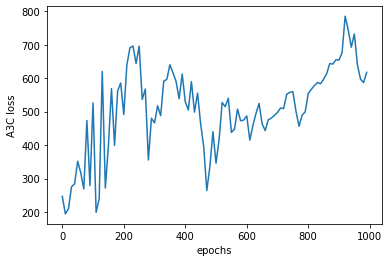

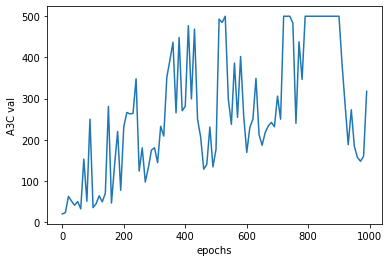

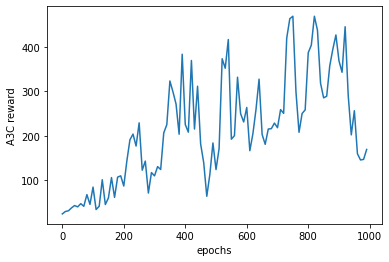

In [ ]:
#the A3C cell
state=torch.load('A3C.pt')
loss=state['loss']
epoch=[10*i for i in range(100)]
plt.plot(epoch,loss)
plt.ylabel('A3C loss')
plt.xlabel('epochs')
plt.show()
eval=state['eval']
plt.plot(epoch,eval)
plt.ylabel('A3C val')
plt.xlabel('epochs')
plt.show()
reward=state['reward']
plt.plot(epoch,reward)
plt.ylabel('A3C reward')
plt.xlabel('epochs')
plt.show()

## Reinforce result( without baseline)
1. It reaches the baseline(500) earlier than the A3C algorithm.
2. Compare with the A3C result, it shows more diversity than A3C. The reason is that it just judge the Q-learning value, so the value will be diverse.
3. Compare with baseline reinforcement, the loss divergence is larger than the baseline, because it does not have a based policy-based result to reduce the loss.
4. overall, the reinforce without baseline performs well, I guess it might due to the cart pole problem is better for Q-learning, because there just two actions. If the agent learning based on the policy, it will be a missed lead.
### Reinforce plot( without baseline)

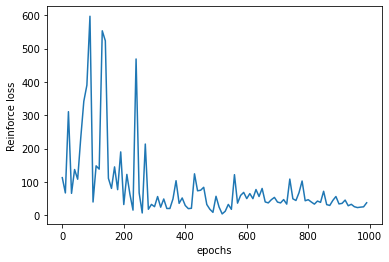

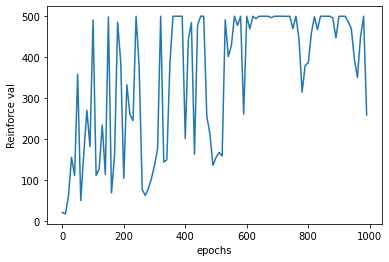

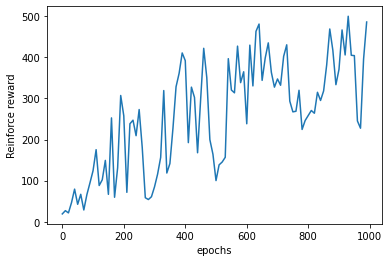

In [ ]:
#the reforce cell

epoch=[10*i for i in range(100)]
state=torch.load('Reinforce.pt')
loss=state['loss']
plt.plot(epoch,loss)
plt.ylabel('Reinforce loss')
plt.xlabel('epochs')
plt.show()
eval=state['eval']
plt.plot(epoch,eval)
plt.ylabel('Reinforce val')
plt.xlabel('epochs')
plt.show()
reward=state['reward']
plt.plot(epoch,reward)
plt.ylabel('Reinforce reward')
plt.xlabel('epochs')
plt.show()

### Reinforce(with baseline) plot


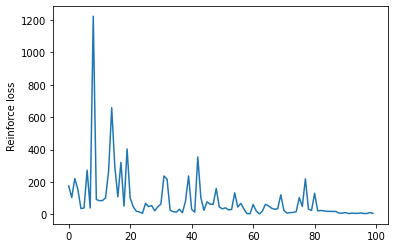

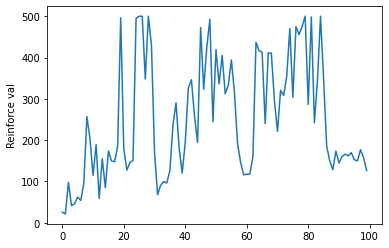

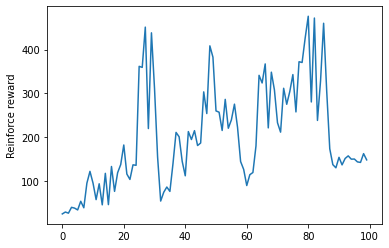

In [ ]:
#the reforce cell
state=torch.load('Reinforce_no_base.pt')
loss=state['loss']
plt.plot(loss)
plt.ylabel('Reinforce loss')
plt.show()
eval=state['eval']
plt.plot(eval)
plt.ylabel('Reinforce val')
plt.show()
reward=state['reward']
plt.plot(reward)
plt.ylabel('Reinforce reward')
plt.show()

## LunarLander with A3C result
1. it is much more difficult than the cart pole problem. Also, the design of the game requests the agent to park the lander in the target area. So I think this means there is some policy that can get more points. So the policy-based revising is important in this question.
2. As the result, A3C performs well in this question.
3. Although I cannot get the 200 on this question( which I search on the internet it might be the solve standard for this question), it seems the reward is much converging than the eval.


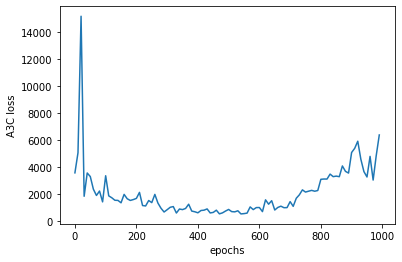

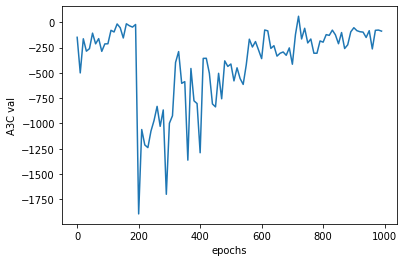

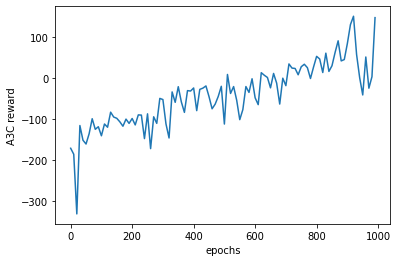

In [ ]:
#the A3C cell
state=torch.load('A3CLL.pt')
loss=state['loss']
epoch=[10*i for i in range(100)]
plt.plot(epoch,loss)
plt.ylabel('A3C loss')
plt.xlabel('epochs')
plt.show()
eval=state['eval']
plt.plot(epoch,eval)
plt.ylabel('A3C val')
plt.xlabel('epochs')
plt.show()
reward=state['reward']
plt.plot(epoch,reward)
plt.ylabel('A3C reward')
plt.xlabel('epochs')
plt.show()

## LunarLander with Reinforce result
1. I try to use the RMSprop to be optimized, however, there shows the runtime error in the torch. gels, so I change the optimizer to Adam.
2. The reinforcement performs worse than the A3C algorithm. I think the reason is that policy learning is important to land the lander. As the chart between baseline and nonbaseline, the nonbaseline one performs better than the non-baseline one. This corresponds to my guess for the LunarLander problem.





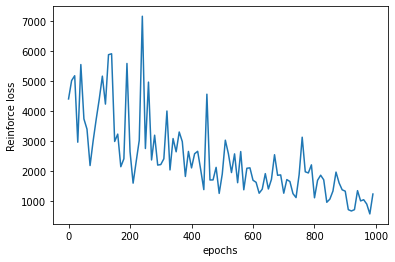

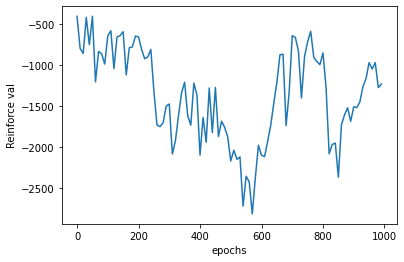

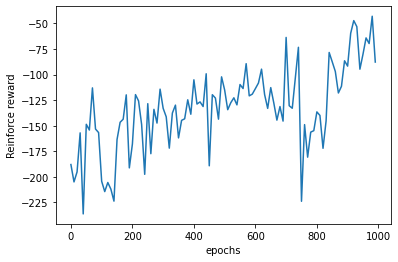

In [ ]:
#the reinforce nonbaseline

epoch=[10*i for i in range(100)]
state=torch.load('Reinforce.pt')
loss=state['loss']
plt.plot(epoch,loss)
plt.ylabel('Reinforce loss')
plt.xlabel('epochs')
plt.show()
eval=state['eval']
plt.plot(epoch,eval)
plt.ylabel('Reinforce val')
plt.xlabel('epochs')
plt.show()
reward=state['reward']
plt.plot(epoch,reward)
plt.ylabel('Reinforce reward')
plt.xlabel('epochs')
plt.show()

### reinforce baseline chart

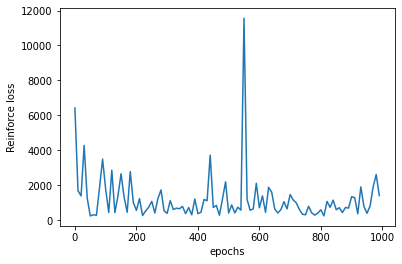

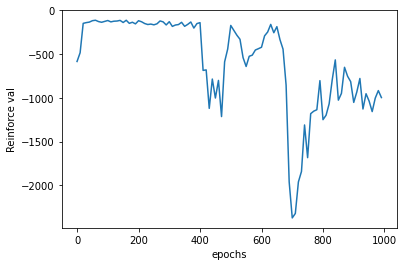

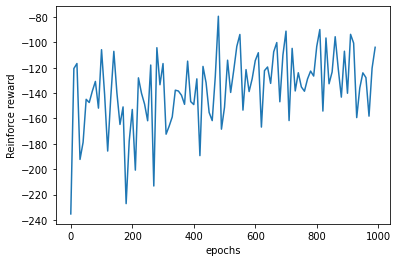

In [ ]:
#the reinforce baseline

epoch=[10*i for i in range(100)]
state=torch.load('Reinforce_b.pt')
loss=state['loss']
plt.plot(epoch,loss)
plt.ylabel('Reinforce loss')
plt.xlabel('epochs')
plt.show()
eval=state['eval']
plt.plot(epoch,eval)
plt.ylabel('Reinforce val')
plt.xlabel('epochs')
plt.show()
reward=state['reward']
plt.plot(epoch,reward)
plt.ylabel('Reinforce reward')
plt.xlabel('epochs')
plt.show()